# Film Thickness

- To run below code, run the `area.ipynb` notebook first, since the sample motion compensation is done there.

Date of experiment: 2016-09-14

In [1]:
# %matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pims
import scipy.optimize as opt
import asdf

import twodpg
import vfetools as vt

In [2]:
plt.style.use('../matplotlibrc')
pltt = sbn.color_palette([c['color'] for c in plt.rcParams['axes.prop_cycle']])
pltt

[(0.0, 0.18823529411764706, 0.43529411764705883),
 (0.0, 0.6235294117647059, 0.5058823529411764),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (1.0, 0.43137254901960786, 0.22745098039215686),
 (0.5176470588235295, 0.0, 0.803921568627451),
 (0.0, 0.5529411764705883, 0.9764705882352941),
 (0.0, 0.5843137254901961, 0.011764705882352941),
 (0.0, 0.7607843137254902, 0.9764705882352941),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (1.0, 0.7647058823529411, 0.23137254901960785)]

## Load Data and Video

In [3]:
polies = vt.FilmPolygons(
    '../data/2016-08-11_run1_polygons_prepped.json', frame_offset=0)
len(polies)

166

In [4]:
polies.frames

array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134,
       136, 138, 140, 141, 149, 157, 165, 173, 181, 197, 209, 221])

In [5]:
len(polies[90])

8

In [6]:
seq = pims.ImageSequence('../data/2016-08-11_run1_frames/*.jpg')
len(seq)

1798

### `show()`

Show a frame and optionally polygons and centroids.

In [7]:
def show(fnum, fpol=None, rpol=None, fcent=None, rcent=None, xlim=None, ylim=None):
    fig, ax = plt.subplots()
    ax.imshow(seq[fnum], zorder=0)
    if fpol is not None:
        ax.add_artist(plt.Polygon(
            fpol, closed=False,
            fill=False, ec=pltt[7], lw=1, zorder=1
        ))
    if rpol is not None:
        ax.add_artist(plt.Polygon(
            rpol, closed=False,
            fill=False, ec=pltt[2], lw=1, zorder=1
        ))
    for cent in (fcent, rcent):
        if cent is not None:
            ax.plot(*cent, 'x', color=pltt[2], ms=8)
    opt = {}
    opt['xlim'] = (rcent[0] - 300, rcent[0] + 300)
    opt['ylim'] = (rcent[1] + 300, rcent[1] - 300)
    if xlim is not None:
        # ax.set_xlim(xlim)
        opt['xlim'] = xlim
    if ylim is not None:
        # ax.set_ylim(ylim)
        opt['ylim'] = ylim
    ax.set(**opt)
    return fig, ax

### Global Constants

- `NBANDS`: Number of vertical bands used.
- `FRATE`: Frame rate of the video; frames per second.
- `IMRES`: Spacial image (video) resolution; mm per pixel.

In [8]:
NBANDS = 10
FRATE = 60000 / 1001
IMRES = 0.07677

Key frames and times:

- `FSTART`, `TSTART`: First contact of sample with water.
- `FREF`, `TREF`: Reference frame from which the sample outline was created.

In [9]:
# FSTART = 634
FSTART = 60
# FSUBM = 648
FSUBM = 74
TSTART = FSTART / FRATE
# FREF = 1200
FREF = 626
TREF = FREF / FRATE

- `YSURF`: Vertical coordinate of initial sample contact.

In [10]:
YSURF = 339

In [11]:
fstart = seq[FSTART]
fsubm = seq[FSUBM]
fref = seq[FREF]

## Key Frames

### First Contact

Frame([[[140, 127, 119],
        [138, 125, 117],
        [135, 122, 114],
        ...,
        [ 64,  62,  67],
        [ 63,  61,  66],
        [ 63,  61,  66]],

       [[143, 130, 122],
        [140, 127, 119],
        [137, 124, 116],
        ...,
        [ 64,  62,  67],
        [ 64,  62,  67],
        [ 64,  62,  67]],

       [[144, 131, 123],
        [143, 130, 122],
        [140, 127, 119],
        ...,
        [ 65,  63,  68],
        [ 65,  63,  68],
        [ 65,  63,  68]],

       ...,

       [[ 85,  83,  84],
        [ 87,  85,  86],
        [ 88,  86,  87],
        ...,
        [ 76,  75,  71],
        [ 76,  75,  71],
        [ 77,  76,  72]],

       [[ 87,  85,  86],
        [ 88,  86,  87],
        [ 89,  87,  88],
        ...,
        [ 76,  75,  71],
        [ 76,  75,  71],
        [ 77,  76,  72]],

       [[ 87,  85,  86],
        [ 89,  87,  88],
        [ 90,  88,  89],
        ...,
        [ 77,  76,  72],
        [ 78,  77,  73],
        [ 78,  77,  73]]], dtype=uint8)
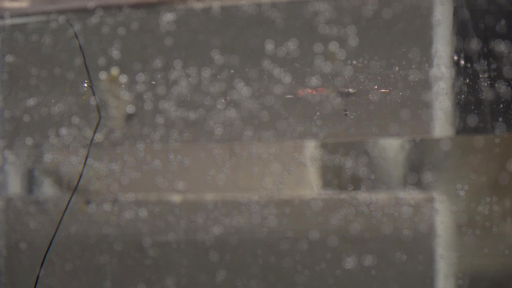

In [12]:
fstart

### Sample Fully Submerged

Frame([[[129, 120, 113],
        [129, 120, 113],
        [128, 119, 112],
        ...,
        [ 58,  54,  55],
        [ 58,  54,  55],
        [ 58,  54,  55]],

       [[129, 120, 113],
        [128, 119, 112],
        [128, 119, 112],
        ...,
        [ 58,  54,  55],
        [ 58,  54,  55],
        [ 58,  54,  55]],

       [[129, 120, 113],
        [128, 119, 112],
        [128, 119, 112],
        ...,
        [ 58,  54,  55],
        [ 58,  54,  55],
        [ 58,  54,  55]],

       ...,

       [[ 78,  78,  80],
        [ 78,  78,  80],
        [ 77,  77,  79],
        ...,
        [ 73,  68,  65],
        [ 72,  67,  64],
        [ 72,  67,  64]],

       [[ 78,  78,  80],
        [ 78,  78,  80],
        [ 77,  77,  79],
        ...,
        [ 72,  67,  64],
        [ 71,  66,  63],
        [ 71,  66,  63]],

       [[ 78,  78,  80],
        [ 78,  78,  80],
        [ 77,  77,  79],
        ...,
        [ 71,  66,  63],
        [ 71,  66,  63],
        [ 71,  66,  63]]], dtype=uint8)
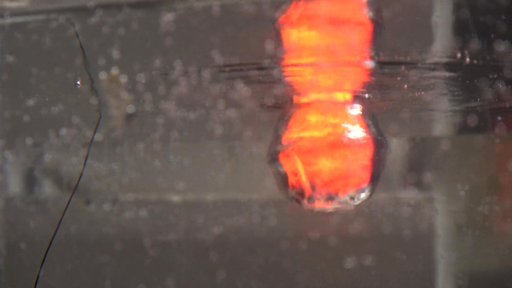

In [13]:
fsubm

### Reference Frame

Frame([[[136, 132, 123],
        [135, 131, 122],
        [133, 129, 120],
        ...,
        [ 68,  68,  68],
        [ 67,  67,  67],
        [ 69,  69,  69]],

       [[137, 133, 124],
        [136, 132, 123],
        [135, 131, 122],
        ...,
        [ 67,  67,  67],
        [ 66,  66,  66],
        [ 68,  68,  68]],

       [[139, 135, 126],
        [138, 134, 125],
        [137, 133, 124],
        ...,
        [ 67,  67,  67],
        [ 66,  66,  66],
        [ 68,  68,  68]],

       ...,

       [[ 87,  86,  91],
        [ 88,  87,  92],
        [ 89,  88,  93],
        ...,
        [ 76,  75,  71],
        [ 75,  74,  70],
        [ 75,  74,  70]],

       [[ 87,  86,  91],
        [ 88,  87,  92],
        [ 89,  88,  93],
        ...,
        [ 75,  74,  70],
        [ 74,  73,  69],
        [ 74,  73,  69]],

       [[ 87,  86,  91],
        [ 88,  87,  92],
        [ 89,  88,  93],
        ...,
        [ 74,  73,  69],
        [ 74,  73,  69],
        [ 73,  72,  68]]], dtype=uint8)
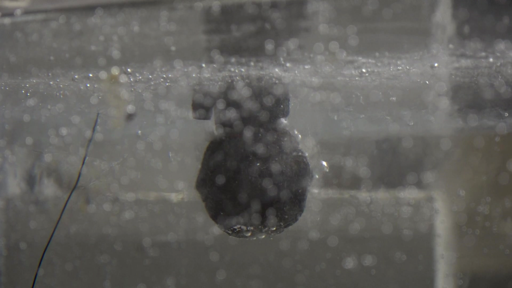

In [14]:
fref

## Compute Film Thickness

### Frame 648

In [15]:
FSUBM

74

In [16]:
648 - 574

74

In [17]:
polies.frames

array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134,
       136, 138, 140, 141, 149, 157, 165, 173, 181, 197, 209, 221])

In [18]:
refshape, flmshape = polies[FSUBM, 'ref', 'film']
ref_r, flm_r, ref_cntr, flm_cntr = vt.radii(refshape, flmshape)

In [19]:
ydep = vt.delta_f(flmshape, refshape, 10)

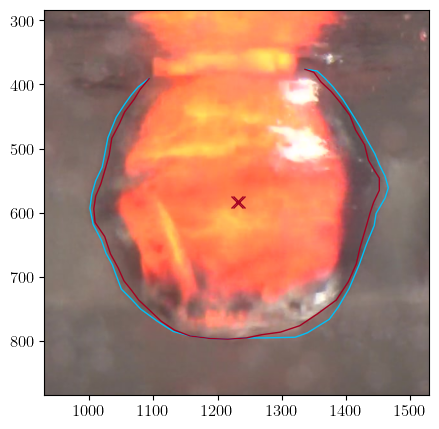

In [20]:
fig, ax = show(FSUBM, fpol=flmshape, rpol=refshape, fcent=flm_cntr, rcent=ref_cntr)

### Frame 75

In [21]:
refshape, flmshape = polies[75, 'ref', 'film']
ref_r, flm_r, ref_cntr, flm_cntr = vt.radii(refshape, flmshape)

In [22]:
ydep = vt.delta_f(flmshape, refshape, 10)

In [23]:
ydep['film']

y     delta
band                  
0     427.35  9.364866
1     468.05  8.957973
2     508.75  8.861209
3     549.45  8.807254
4     590.15   8.91388
5     630.85  7.117844
6     671.55  4.663697
7     712.25  5.883736
8     752.95  4.385062
9     793.65  0.251727

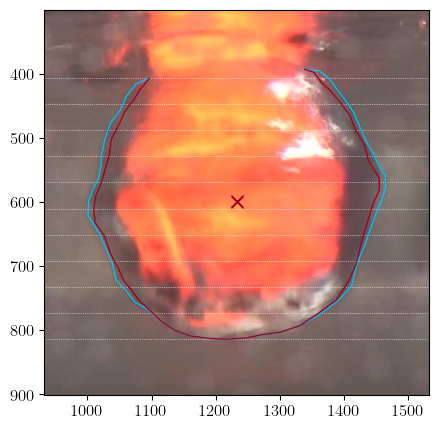

In [24]:
fig, ax = show(75, fpol=flmshape, rpol=refshape, fcent=flm_cntr, rcent=ref_cntr)
ax.hlines(
    list(ydep['film'].y - .5 * ydep['bandwidth'])
    + [ydep['film'].y[9] + .5 * ydep['bandwidth']],
    *ax.get_xlim(),
    color='white', lw=.5, ls='dotted', zorder=.5)

### All Frames

All frames for which a 'film' polygon exists.

In [25]:
fnums = []
for fnum in polies.frames:
    try:
        polies[fnum, "film"]
        fnums.append(fnum)
    except KeyError:
        pass
print(fnums)

[73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141]


In [26]:
δthr = 0.75
data = {}
for fnum in fnums:
    try:
        ref, flm = polies[fnum, 'ref', 'film']
    except KeyError:
        print(f"Skipping frame {fnum}.")
        continue
    frm = vt.delta_f(flm, ref, NBANDS)
    vt.mean_thickn(frm, NBANDS, write_to_frame=True, thr=δthr)
    data[fnum] = frm

## Check Results

### Example Frame 75

#### Plot the y-Segments

This shows the sub-polygons from which thickness is actually camputed. Because during
the manual markup no attention is given to the number and location of the vertical segments
additional end points are inserted at the intersection points of a polygon and y-segment border.
This is done by the `vt.segments()` function, which is called by `vt.delta_f()`.

In [27]:
f75 = data[75]
film = f75['film']
segs = f75['segments']['inner']

In [28]:
ref, flm = polies[75, 'ref', 'film']

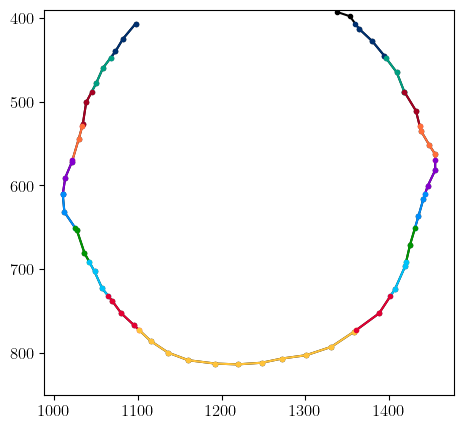

In [29]:
fig, ax = plt.subplots()

ax.set_aspect(1)
ax.set_ylim(850, 390)
# ax.set_xlim(1075, 1125)
for seg in f75['segments']['inner']['left']:
    ax.plot(seg[:, 0], seg[:, 1], marker='.', ls='solid', zorder=1)
seg = f75['segments']['inner']['center']
ax.plot(seg[:, 0], seg[:, 1], marker='.', ls='solid', zorder=1)
for seg in f75['segments']['inner']['right']:
    ax.plot(seg[:, 0], seg[:, 1], marker='.', ls='solid', zorder=1)
    
ax.plot(ref[:, 0], ref[:, 1], marker='.', color='k', ls='solid', zorder=0)

#### Check Segment- and Polygon Lengths

Total length of sample polygon segments vs. total length of original polygon.
The difference is the length cut from requiring that the top segment ends at the same
y-coordinate.

In [30]:
s = np.array([vt.pol_lengths(seg).sum() for seg in f75['segments']['inner']['left']]).sum()
s += vt.pol_lengths(f75['segments']['inner']['center']).sum()
s += np.array([vt.pol_lengths(seg).sum() for seg in f75['segments']['inner']['right']]).sum()

In [31]:
s / vt.pol_lengths(ref).sum()

0.9764522384649396

In [32]:
f75['centroid']

array([1232.73521271,  599.72804847])

### All Analyzed Frames

Arrays for all frames:

- `δmean`: Mean thickness averaged over whole sample.
- `covered_l`: Length of sample outline that has thickness larger than threshold.
- `direct_l`: Length of sample outline that has thickness smaller than threshold.
- `cent_y`: $y$-coordinate of sample's centroid.

In [33]:
δmean = np.array([data[fnum]['delta_mean'] for fnum in data.keys()])
covered_l = np.array([data[fnum]['length_film'] for fnum in data.keys()])
direct_l = np.array([data[fnum]['length_direct'] for fnum in data.keys()])
cent_y = np.array([data[fnum]['centroid'][1] for fnum in data.keys()])

- `t`: Time after first contact of each analyzed frame (not compensated for sample motion).

In [34]:
t = (fnums - fnums[0] + FSUBM - FSTART) / FRATE

- `deltas`: $\langle\delta\rangle$ per y-segment in mm for each frame

In [35]:
deltas = np.empty((len(fnums), NBANDS))

for i, fnum in enumerate(fnums):
    deltas[i, :] = data[fnum]['film']['delta'].values * IMRES

- `ys`: Lower band boundaries in mm above sample bottom  
  This is in up -> down sequence.

In [36]:
ys = (f75['film']['y'].values[-1] - f75['film']['y'].values) * IMRES
ys

array([28.120851, 24.996312000000003, 21.871773000000005,
       18.747234000000006, 15.622695, 12.498155999999998,
       9.373617000000003, 6.249077999999999, 3.124538999999995, 0.0],
      dtype=object)

#### Plot Analysis

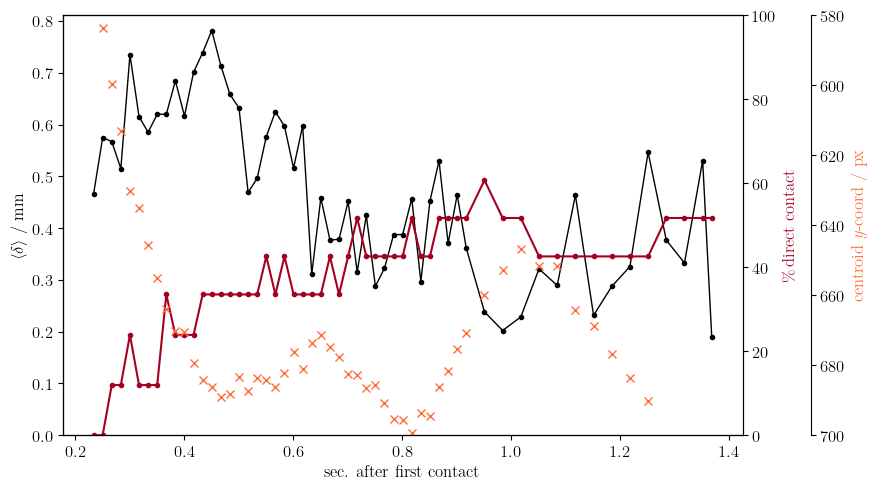

In [37]:
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.spines.right.set_position(("axes", 1.1))
ax.plot(t, δmean * IMRES, color='k', lw=1, ls='solid', marker='o', ms=3)
ax.set(xlabel=r'sec. after first contact',
       ylabel=r'$\langle\delta\rangle\ /\ \mathrm{mm}$',
       ylim=(0, None))
ax2.plot(t, 100 * direct_l / (covered_l + direct_l),
         color=pltt[2], marker='.', ls='solid')
ax2.set_ylim(0, 100)
ax2.set_ylabel(r'$\%\,\text{direct contact}$', color=pltt[2])
ax3.plot(t, cent_y, 'x', color=pltt[3])
ax3.set_ylim(700, 580)
ax3.set_ylabel(r'centroid $y$-coord / px', color=pltt[3])
fig.subplots_adjust(left=.05, right=.85, top=.95)

### Compensate Time Line for Sample Motion

This was already done in the `areas.ipynb` notebook.

In [38]:
af = asdf.open('data/run1_alldata.asdf', mode='r')

In [39]:
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata) ...
├─area (dict)
│ ├─direct (NDArrayType): shape=(62, 10), dtype=float64
│ ├─fit (NDArrayType): shape=(6, 2), dtype=float64
│ ├─ref (NDArrayType): shape=(62, 10), dtype=float64
│ ├─rel (NDArrayType): shape=(62, 10), dtype=float64
│ ├─t (NDArrayType): shape=(62,), dtype=float64
│ ├─tthr (NDArrayType): shape=(5,), dtype=float64
│ ├─yb_centers (NDArrayType): shape=(10,), dtype=float64
│ └─ythr (NDArrayType): shape=(5,), dtype=float64
├─frames_analyzed (NDArrayType): shape=(62,), dtype=int64
├─key_frames (dict) ...
├─raw (dict) ...
├─thickness (dict) ...
└─time (dict) ...
Some nodes not shown.


- `tf`: Per y-segment time corrections for first contact.  
  Comes as down -> up sequence.

In [40]:
tf = af['time']['tf']

In [41]:
tf

array([0.00531177, 0.02019909, 0.03888483, 0.05521148, 0.07060099,
       0.08946624, 0.10608789, 0.12274067, 0.1430474 , 0.16653378])

In [42]:
ys[::-1]

array([0.0, 3.124538999999995, 6.249077999999999, 9.373617000000003,
       12.498155999999998, 15.622695, 18.747234000000006,
       21.871773000000005, 24.996312000000003, 28.120851], dtype=object)

### Fit Data to Exponential

We use data for the (sample motion adjusted) time window once the sample has stopped moving in ($t_\text{adj}\geq0.2\,\mathrm{s}$).

In [43]:
idx = t > .2 + tf[9]
idx

array([False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [44]:
ys

array([28.120851, 24.996312000000003, 21.871773000000005,
       18.747234000000006, 15.622695, 12.498155999999998,
       9.373617000000003, 6.249077999999999, 3.124538999999995, 0.0],
      dtype=object)

In [45]:
tf

array([0.00531177, 0.02019909, 0.03888483, 0.05521148, 0.07060099,
       0.08946624, 0.10608789, 0.12274067, 0.1430474 , 0.16653378])

In [46]:
xd, yd, lns = [], [], [0]
for i in range(5):
    idx = t > .2 + tf[i]
    lns.append(np.count_nonzero(idx) + lns[i])
    xd += list(t[idx])
    yd += list(deltas[idx, 9 - i])

The fit model is an exponential with a common initial 'amplitude', $\delta_0$, for all
segments and per-segment decay constants $t_{0,i}$

$$
\langle\delta\rangle = \delta_0\,e^{-t/t_{0,i}}
$$

In order to fit this, all fitted segments have to be processes at once

In [47]:
def model(x, y0, a0, a1, a2, a3, a4):
    a = (a0, a1, a2, a3, a4)
    ret = np.empty(len(x))
    for i in range(5):
        ret[lns[i]:lns[i + 1]] = y0 * np.exp(-x[lns[i]:lns[i + 1]] / a[i])
    return ret

In [48]:
def model_single(x, y0, a):
    return y0 * np.exp(-x / a)

In [49]:
lns

[0, 56, 112, 167, 221, 274]

In [50]:
res = opt.curve_fit(
    model, xd, yd,
    bounds=(
        [0, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2],
        [5, 1, 1, 1, 1, 1]
    )
)
res

(array([2.05878571, 0.0908614 , 0.13768112, 0.16026783, 0.22462754,
        0.29910005]),
 array([[ 3.61711982e-02, -5.20459858e-04, -1.07304538e-03,
         -1.31969055e-03, -2.20277326e-03, -3.37402056e-03],
        [-5.20459858e-04,  9.40277611e-05,  1.54398271e-05,
          1.89887532e-05,  3.16952469e-05,  4.85480811e-05],
        [-1.07304538e-03,  1.54398271e-05,  7.78293371e-05,
          3.91495974e-05,  6.53468998e-05,  1.00092818e-04],
        [-1.31969055e-03,  1.89887532e-05,  3.91495974e-05,
          9.48356631e-05,  8.03672314e-05,  1.23099684e-04],
        [-2.20277326e-03,  3.16952469e-05,  6.53468998e-05,
          8.03672314e-05,  1.80617599e-04,  2.05472935e-04],
        [-3.37402056e-03,  4.85480811e-05,  1.00092818e-04,
          1.23099684e-04,  2.05472935e-04,  3.67612018e-04]]))

In [51]:
tp = np.linspace(0, 1.3, 300)

### Plot Data and Fit

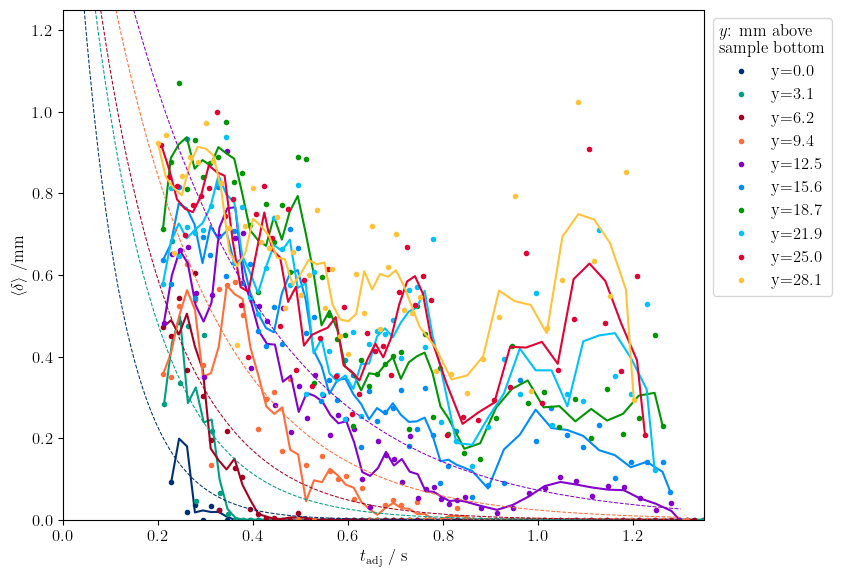

In [52]:
fig, ax = plt.subplots(figsize=(8.5, 6))

for i, y in enumerate(ys[::-1]):
    idx = t > .2 + tf[i]
    l, = ax.plot(t[idx] - tf[i], deltas[idx, -i-1],
                 ls='none', marker='.', label=f'y={y:.1f}')
    ax.plot(t[idx] - tf[i], vt.moving_avg(deltas[idx, -i-1], 3),
            color=l.get_color())

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1),
          title='$y$: mm above\nsample bottom')
fig.subplots_adjust(right=.85)
ax.set(
    xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$',
    ylabel=r'$\langle \delta\rangle\ / \mathrm{mm}$',
    xlim=(0, 1.35), ylim=(0, 1.25)
)
fig.subplots_adjust(top=.95, left=.075, bottom=.1, right=.83)

for i in range(5):
    ax.plot(tp, model_single(tp, res[0][0], res[0][i + 1]),
            ls='dashed', lw=.75, color=pltt[i])

### Minimum Detectable Thickness

In [53]:
ys = np.asarray(ys, dtype=float)

In [54]:
ydp = ys[-1:-6:-1] + .5 * (ys[-2] - ys[-1])

In [55]:
tdp = res[0][1:] * np.log(100)
tdp

array([0.41843223, 0.63404499, 0.73806062, 1.03444803, 1.37740663])

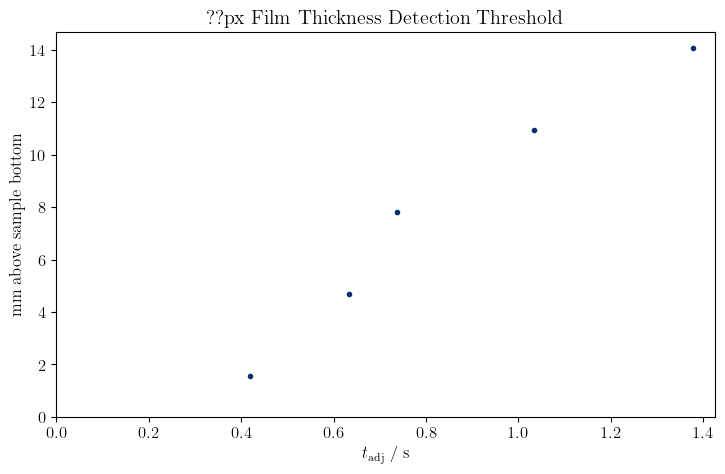

In [56]:
fig, ax = plt.subplots()

ax.plot(tdp, ydp, '.')
ax.set(
    xlim=(0, None), ylim=(0, None),
    xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$',
    ylabel=r'mm above sample bottom',
    title=r'??px Film Thickness Detection Threshold'
);

### Frame 93: Nice Example Sid-By-Side Plot for Frontiers Pub

Location of y-bands, starting at the top, to match order of `deltas`

In [57]:
ybands = vt.bands(polies[93, 'ref'][0])[::-1]
ybands

array([494. , 534.7, 575.4, 616.1, 656.8, 697.5, 738.2, 778.9, 819.6,
       860.3, 901. ])

In [58]:
-(ybands - ybands[-1])

array([407. , 366.3, 325.6, 284.9, 244.2, 203.5, 162.8, 122.1,  81.4,
        40.7,  -0. ])

In [59]:
deltas[20]

array([8.12664298e-01, 8.18356911e-01, 7.38981753e-01, 7.72706285e-01,
       7.12443005e-01, 3.27410256e-01, 1.34423570e-01, 4.36386615e-17,
       3.67917723e-16, 7.11709069e-16])

In [60]:
f93 = data[93]

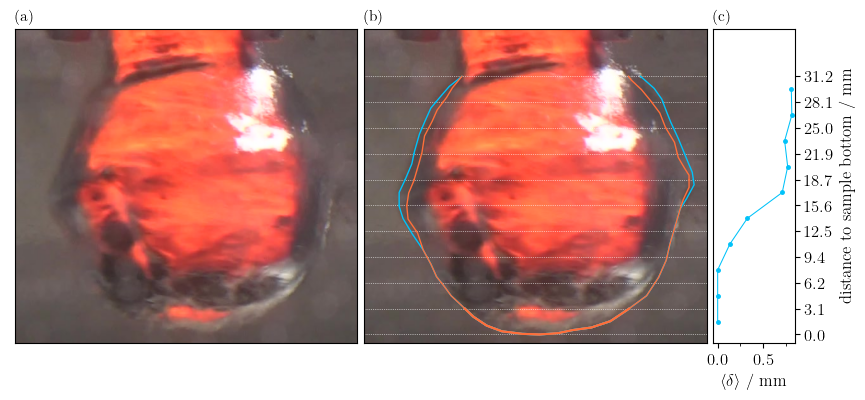

In [61]:
fig, axd = plt.subplot_mosaic('aaaabbbbc', figsize=(8.5, 4))
ax1, ax2, ax3 = axd['a'], axd['b'], axd['c']
ax1.imshow(seq[93])
xlim, ylim = (840, 1380), (915, 420)
ax1.set(ylim=ylim, xlim=xlim, yticks=[], xticks=[])
ax1.set_title('(a)', loc='left', fontsize=11)
ax2.imshow(seq[93])
ax2.hlines(ybands, *ax2.get_xlim(), color='white', lw=.5, ls='dotted', zorder=.5)
for pol, clr in zip(('outer', 'inner'), (pltt[7], pltt[3])):
    for side in ('left', 'right'):
        for seg in f93['segments'][pol][side]:
            ax2.plot(seg[:, 0], seg[:, 1], color=clr, lw=1)
        seg = f93['segments'][pol]['center']
        ax2.plot(seg[:, 0], seg[:, 1], color=clr)
ax2.set(xlim=xlim, ylim=ylim, yticks=[], xticks=[])
ax2.set_title('(b)', loc='left', fontsize=11)
ax3.plot(deltas[20, :], ybands[1:] + .5 * (ybands[0] - ybands[1]),
         ls='solid', lw=.75, marker='.', ms=5, color=pltt[7])
ax3.set(
    xlabel=r'$\langle\delta\rangle\ /\ \mathrm{mm}$',
    xlim=(-.05, .85), ylim=ylim,
    aspect=.007,
    yticks=ybands,
    yticklabels=[f'{y + 1e-4:2.1f}' for y in -(ybands - ybands[-1]) * IMRES],
    ylabel=r'distance to sample bottom / mm',
)
ax3.set_xticks([0, .5]); ax3.set_xticks([.25, .75], minor=True)
ax3.set_title('(c)', loc='left', fontsize=11)
ax3.yaxis.set_ticks_position('right')
ax3.yaxis.set_label_position('right')
fig.subplots_adjust(top=.95, bottom=.165, left=.01, right=.93, wspace=.05)

## Export to `asdf`

In [62]:
res[0][1:]

array([0.0908614 , 0.13768112, 0.16026783, 0.22462754, 0.29910005])

In [63]:
def export():
    af = asdf.open('data/run1_alldata.asdf', mode='rw')
    af.info()
    if 'thickness' not in af.keys():
        af['thickness'] = {}
    afthick = af['thickness']
    afthick['t'] = t
    afthick['y'] = ys[::-1]
    afthick['delta'] = deltas[:, ::-1]
    afthick['fit'] = {
        'y': ydp,
        'delta0': res[0][0],
        'tr': res[0][1:]
    }
    af.write_to(af.uri, all_array_compression='zlib')
    af.close()